# Algorithme NPGA pour la résolution d'un problème d'optimisation multi objectifs

L'algorithme se base sur cet workflow



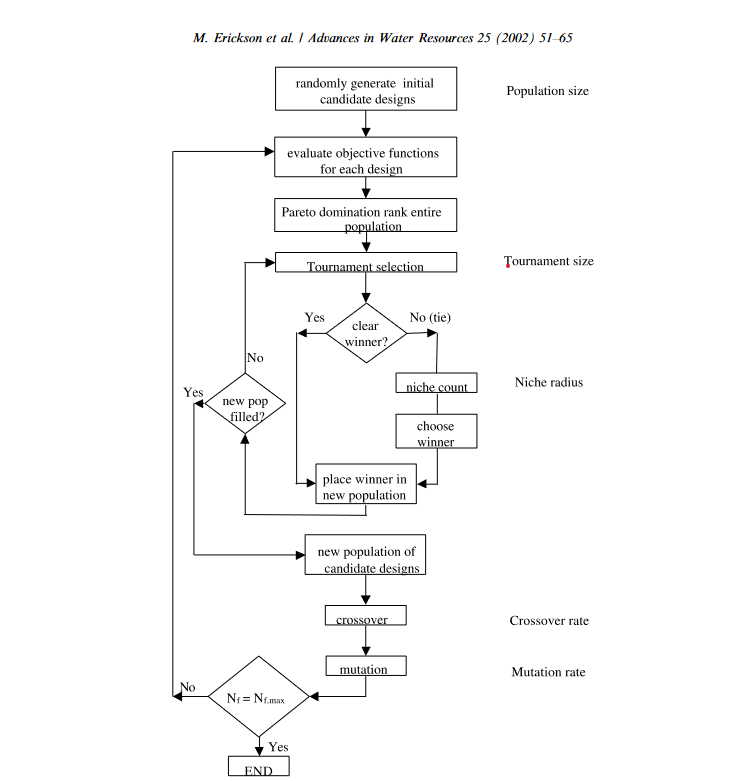

In [173]:
import math
import numpy
import random

In [194]:
tasks = [] # Les tâches à effectuer
indiv_length = 0 # Taille d'un individu
vms = [] # Les vms disponibles avec leurs caractèristiques
vm_number = 0 # Nombre de vm utilisable

mutation_rate = 0.3
sharing_factor = 2000 # Taux pour modifier la sharing fitness -> plus il est grand, plus les solutions dominantes seront avantagées, et plus il est petit, plus ca sera égalitaire (si trop petit, peut faire planter le programme avec des divisions par 0)
iteration_number = 5 # Nombre d'itération de l'algorithme
population_size = 20

budget = 2000
transport_cost = 5
speed = 1
transport_speed = 10

In [175]:
class vm:
  def __init__(self,price,capacity,distance,power) -> None:
    self.price = price
    self.capacity = capacity
    self.distance = distance
    self.power = power

# Fonctions générales

In [176]:
def is_valid(indiv) -> bool:
  cost = 0
  overload= numpy.zeros(vm_number)
  for i in range(0,indiv_length-1):
    vm = vms[indiv[i]]
    
    cost += vm.price*tasks[i] + transport_cost*vm.distance
    if cost > budget:
      return False
      break

    overload[indiv[i]] += tasks[i]/vm.power
    if overload[indiv[i]] > vm.capacity:
      return False
      break
  return True

In [177]:
def fitness(indiv) -> tuple:
  cost = 0
  exec_time = numpy.zeros(vm_number)
  latency = 0

  for i in range(0,indiv_length-1):
    vm = vms[indiv[i]]

    cost += vm.price*tasks[i] + transport_cost*vm.distance

    exec_time[indiv[i]] += tasks[i]/vm.power

    latency += vm.distance/speed + tasks[i]/transport_speed

  return (cost,max(exec_time),latency)

In [178]:
def init_data() -> None:
  global vms 
  vms = [vm(1.2, 30, 100, 5),vm(2,40,70,20),vm(1,10,20,4),vm(1.5,25,100,30)]
  global tasks
  tasks = [10,2,5,4]
  global vm_number
  vm_number = len(vms)
  global indiv_length
  indiv_length = len(tasks)

  return vms, tasks

In [179]:
def init_population() -> list:
  population = []
  while len(population) < population_size:
   
    indiv= numpy.zeros(indiv_length)

    indiv = [random.randint(0,vm_number-1) for elem in indiv]
    
    if is_valid(indiv):
      population.append(indiv)
  return population

# Agents génétiques

##Séléction des parents

In [180]:
def parent_selection(population) -> tuple:
    
  return random.sample(population,k=2)

In [181]:
'''
population = [
    (1,3),
    (4,2),
    (1,2),
    (3,3),
    (1,5),
    (0,1)
]

res = parent_selection(population)

print(res)
'''

'\npopulation = [\n    (1,3),\n    (4,2),\n    (1,2),\n    (3,3),\n    (1,5),\n    (0,1)\n]\n\nres = parent_selection(population)\n\nprint(res)\n'

## Création des enfants

In [182]:
def crossover(parent1, parent2) -> tuple:
  
  length = len(parent1)
  pivot = math.floor(length/2)
  child1 = parent1[0:pivot] + parent2[pivot:length]
  child2 = parent2[0:pivot] + parent1[pivot:length]

  return child1,child2

In [183]:
'''
parent1=(9,9,9,9,9,9,9,9)
parent2=(1,1,1,1,1,1,1,1)
res = crossover(parent1,parent2)

print(res)
'''

'\nparent1=(9,9,9,9,9,9,9,9)\nparent2=(1,1,1,1,1,1,1,1)\nres = crossover(parent1,parent2)\n\nprint(res)\n'

## Mutation

In [184]:
def multiple_swap(child) -> list:
  return child

def swap(child) -> list:
  save = child

  x = random.randint(0,indiv_length-1)
  y = random.randint(0,indiv_length-1)
  tmp = child[x]
  child[x] = child[y]
  child[y] = tmp
  while not is_valid(child):
    
    child = swap(save)
  return child

def value_change(child) -> list:
  save = child
  
  index = random.randint(0,indiv_length-1)
  new_value = random.randint(0,vm_number-1)
  child[index]= new_value
  while not is_valid(child):
    
    child = value_change(save)
  return child

def mutation(mutation_rate,child) -> list:
  
  if mutation_rate > 1 :
    print("Taux de mutation trop élevé")
    return child
  
  rd = random.random()

  if mutation_rate > rd:
    mutation_type = random.random()*2
    if mutation_type < 1:
      return swap(child)
    return value_change(child)
  return child

In [185]:
'''
child = [1,2,3,4,5,6,7,8,9,10]

res = mutation(1,child)

print(res)
'''

'\nchild = [1,2,3,4,5,6,7,8,9,10]\n\nres = mutation(1,child)\n\nprint(res)\n'

# Tournois de séléction

In [186]:
# Cette cellule  permet de faire un combat entre deux individus sur un population donné et de soit renvoyer le gagnant (True,_) soit déclarer un match nul (False,0)



# Fonction qui permet de savoir si un individu en domine un autre

# Prend en entrée la fitness des deux individus
# Renvoie en sortie False si l'individu 2 domine l'individu 1. Renvoie True sinon

def dominance_check(fit1,fit2) -> bool:
  if (fit1[0] >= fit2[0] and fit1[1] > fit2[1]) or (fit1[0] > fit2[0] and fit1[1] >= fit2[1]):
    return False
  else:
    return True



# Fonction qui effectue les matchs

# Prend en entrée les deux individus et la sous population sur laquelle ils vont se battre
# Renvoie (False,0) si les individus sont dominés ou domine toute la sous population
# Renvoie (True,_) si un individu est gagnant, "_" étant cet individu

def match_tournois(indiv1,indiv2,population_fit) -> tuple :
  fit1 = fitness(indiv1)
  fit2 = fitness(indiv2)

  res_indiv1 = True
  res_indiv2 = True
  i = 0
  
  while (res_indiv1 or res_indiv2) and i < len(population_fit) :
    
    if res_indiv1:
      res_indiv1 = dominance_check(fit1,population_fit[i])
    
    if res_indiv2:
      res_indiv2 = dominance_check(fit2,population_fit[i])

    i += 1 

  if not (res_indiv1 ^ res_indiv2):
    return (False,0)
  
  if res_indiv1:
    return (True, indiv1)

  else:
    return (True, indiv2)

In [187]:
'''
indiv1 = [1,2]
indiv2 = [0,1]
population = [
    [1,3],
    [4,2],
    [1,2],
    [3,3],
    [1,5],
    [0,1]
]


res = match_tournois(indiv1,indiv2, population)

print(res)

# res doit etre égale à (True, [0, 1])
'''

'\nindiv1 = [1,2]\nindiv2 = [0,1]\npopulation = [\n    [1,3],\n    [4,2],\n    [1,2],\n    [3,3],\n    [1,5],\n    [0,1]\n]\n\n\nres = match_tournois(indiv1,indiv2, population)\n\nprint(res)\n\n# res doit etre égale à (True, [0, 1])\n'

In [188]:
# Fonction qui permet de calculer la "shared fitness" d'un individu par rapport à une population


# Fonction à vectoriser pour calculer le niche count d'un individu

def sharing_function(indiv1, indiv2) -> float:
  distance = math.sqrt((indiv1[0]-indiv2[0])*(indiv1[0]-indiv2[0])+(indiv1[1]-indiv2[1])*(indiv1[1]-indiv2[1]))
  sh = 1 - (distance/sharing_factor)
  if sh < 0:
    sh = 0
  return sh


# Prend en entrée la fitness d'un individu et la fitness de la population
# Renvoie en sortie la "shared fitness" de l'individu

def sharing_procedure(indiv, population_fit) -> float:
  
  fit = indiv

  vectorized_sharing = numpy.vectorize(sharing_function, signature ='(n),(m)->()')
  
  niche_count = sum(vectorized_sharing(fit,population_fit))
  return numpy.mean(fit)/niche_count

In [189]:
'''
individual = [1,2]
population = [
    [1,3],
    [4,2]
]


res = sharing_procedure(individual, population)

print(res)

# Res doit etre égale à 0.8333333333333334
'''

'\nindividual = [1,2]\npopulation = [\n    [1,3],\n    [4,2]\n]\n\n\nres = sharing_procedure(individual, population)\n\nprint(res)\n\n# Res doit etre égale à 0.8333333333333334\n'

In [190]:
def tournois(population,winner_length)->list:
  winners = {}
  winners['indiv']=[]
  winners['shared_fitness']=[]
  while len(winners['indiv']) < winner_length:
    indiv1 = random.choice(population)
    indiv2 = random.choice(population)

    while indiv1 == indiv2 :
      
      indiv2 = random.choice(population)

    population_fit = list(map(fitness, population))
    sub_pop_len = random.randint(1,len(population))
    sub_pop = random.choices(population_fit,k=sub_pop_len)

    (res,winner) = match_tournois(indiv1,indiv2,sub_pop)

    # If there is a clear winner
    if res:
      winners['indiv'].append(winner)
      winners['shared_fitness'].append(0)
      continue
    
    # If there isnt a clear winner, compare shared fitness
    sf1 = sharing_procedure(indiv1,population)
    sf2 = sharing_procedure(indiv2,population)
    if sf1 <= sf2:
      winners['indiv'].append(indiv1)
      winners['shared_fitness'].append(sf1)
    else:
      winners['indiv'].append(indiv2)
      winners['shared_fitness'].append(sf2)

  return winners

In [191]:
'''
population = [
    [1,3],
    [4,2],
    [1,2],
    [3,3],
    [1,5],
    [0,1]
]

res = tournois(population,3)

print(res)
'''

'\npopulation = [\n    [1,3],\n    [4,2],\n    [1,2],\n    [3,3],\n    [1,5],\n    [0,1]\n]\n\nres = tournois(population,3)\n\nprint(res)\n'

# Main

In [192]:
def main() -> list:
  vms, tasks = init_data()
  population = init_population()
  for i in range(0,iteration_number):
    winners = tournois(population, population_size)["indiv"]

    new_pop = []
    while len(winners) > 1:
      parent1, parent2 = parent_selection(winners)
      child1, child2 = crossover(parent1, parent2)
      new_pop.append(mutation(mutation_rate, child1))
      new_pop.append(mutation(mutation_rate, child2))
      winners.remove(parent1)
      winners.remove(parent2)
    if len(winners) == 1:
      population.append(winners[0])
    population = new_pop

  winners = tournois(population, population_size)
  sorted(winners["shared_fitness"])
  print(winners["indiv"])
  i = 0
  while winners["shared_fitness"][i]==0 and i < population_size:
    print("Solution de Pareto ", i, "= ", winners["indiv"][i])
    i += 1

In [199]:
main()

[[1, 0, 1, 2], [1, 1, 2, 1], [1, 2, 3, 0], [1, 0, 3, 0], [1, 2, 2, 1], [1, 0, 0, 0], [1, 0, 2, 1], [1, 1, 2, 1], [1, 0, 0, 0], [1, 0, 3, 0], [1, 0, 2, 1], [1, 2, 2, 0], [1, 0, 3, 0], [1, 2, 2, 1], [1, 0, 3, 0], [1, 0, 1, 2], [1, 0, 3, 0], [1, 0, 0, 0], [1, 2, 2, 1], [1, 2, 3, 0]]
Solution de Pareto  0 =  [1, 0, 1, 2]
Solution de Pareto  1 =  [1, 1, 2, 1]
Solution de Pareto  2 =  [1, 2, 3, 0]
